In [80]:
#-----------------------------------
# GLOBAL FEATURE EXTRACTION
#-----------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py



import h5py
import glob
import warnings
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import joblib

#--------------------
# tunable-parameters
#--------------------
images_per_class       = 800
fixed_size             = tuple((500, 500))
train_path             = "/Final_Datasets/Diseased_+_Healthy"
h5_train_data          = '/tier1/output/train_data.h5'
h5_train_labels        = '/tier1/output/train_labels.h5'
bins                   = 8

resultsdic = {}
finalres = []

In [81]:
# Converting each image to RGB from BGR format

def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img


In [82]:
# Conversion to HSV image format from RGB

def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img

In [83]:
# image segmentation

# for extraction of green and brown color


def img_segmentation(rgb_img,hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result


In [84]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [85]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [86]:
# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [87]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['diseased', 'healthy']


In [88]:
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = train_path + "/" + training_name
    #dir = os.path.join(train_path, training_name)
    print(dir)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    #for x in range(1,images_per_class+1):
    for x in os.listdir(dir):
        # get the image file name
        file = dir + "/" + str(x)

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        
        # Running Function Bit By Bit
        
        RGB_BGR       = rgb_bgr(image)
        BGR_HSV       = bgr_hsv(RGB_BGR)
        IMG_SEGMENT   = img_segmentation(RGB_BGR,BGR_HSV)

        # Call for Global Fetaure Descriptors
        
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick   = fd_haralick(IMG_SEGMENT)
        fv_histogram  = fd_histogram(IMG_SEGMENT)
        
        # Concatenate 
        
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        
        

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

C:/Users/johan/OneDrive/Documents/GitHub/DGMD-S-17/Final_Datasets/Diseased_+_Healthy/diseased
[STATUS] processed folder: diseased
C:/Users/johan/OneDrive/Documents/GitHub/DGMD-S-17/Final_Datasets/Diseased_+_Healthy/healthy
[STATUS] processed folder: healthy
[STATUS] completed Global Feature Extraction...


In [89]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

[STATUS] feature vector size (1709, 532)


In [90]:
# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

[STATUS] training Labels (1709,)


In [91]:
# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

[STATUS] training labels encoded...


In [92]:
# scale features in the range (0-1)
from sklearn.preprocessing import MinMaxScaler
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

[STATUS] feature vector normalized...


In [93]:
print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] target labels: [0 0 0 ... 1 1 1]
[STATUS] target labels shape: (1709,)


#### **Save Feature Vector using HDF5**

In [94]:
print(h5_train_data)
h5f_data = h5py.File(h5_train_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(h5_train_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

C:/Users/johan/OneDrive/Documents/GitHub/DGMD-S-17/NewSklearn/output/train_data.h5


#### **Algorithm Training**
**CNN, KNN, SVM**

In [95]:
# training
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------

warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.20
seed      = 9
train_path = "/Final_Datasets/Diseased_+_Healthy"
test_path  = "/tier1/test"
h5_train_data    = '/tier1/output/train_data.h5'
h5_train_labels  = '/tier1/output/train_labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(random_state=seed)))


# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_train_data, 'r')
h5f_label = h5py.File(h5_train_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))
print("[STATUS] training started...")


[STATUS] features shape: (1709, 532)
[STATUS] labels shape: (1709,)
[STATUS] training started...


In [96]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] split train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape)) 

[STATUS] split train and test data...
Train data  : (1367, 532)
Test data   : (342, 532)


In [97]:
trainDataGlobal
print(trainDataGlobal.shape)

(1367, 532)


In [98]:
# 10-fold cross validation, iterating over the three algorithms.

for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    names.append(name)
    resultsdic[name] = cv_results.mean()
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.917341 (0.043566)
KNN: 0.930523 (0.025313)
SVM: 0.918076 (0.038037)


In [99]:
#clf.fit(trainDataGlobal, trainLabelsGlobal)

Keymax = max(zip(resultsdic.values(), resultsdic.keys()))[1]
ik = 0
while ik < len(models) - 1:
    if Keymax == models[ik][0]:
        m = models[ik][1]
        print(Keymax + ' has highest score. Using ' + str(m))
    else:
        pass
    ik += 1

m.fit(trainDataGlobal, trainLabelsGlobal)
y_predict = m.predict(testDataGlobal)

print(y_predict)

# Finding Out How To Display What The Result Is

#for key in resultsdic:
    
    #newres.fit(resultsdic[key],np.arrange(0,len(resultsdic[key]-1)))
    #y_predict=newres.predict(len(resultsdic[key])+1)
    #finalres.append(y_predict)

#numpy.argmax()

KNN has highest score. Using KNeighborsClassifier()
[1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0
 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 0
 1 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1
 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 0
 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 1 1
 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1
 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0
 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1
 0 1 1 0 1 1 0 1 0]


In [100]:
cm = confusion_matrix(testLabelsGlobal,y_predict)

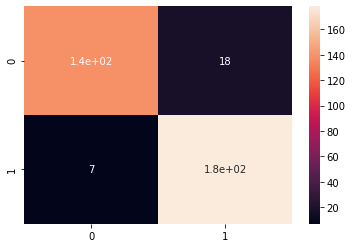

In [101]:
import seaborn as sns
sns.heatmap(cm ,annot=True)

In [102]:
print(classification_report(testLabelsGlobal,y_predict))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       157
           1       0.91      0.96      0.93       185

    accuracy                           0.93       342
   macro avg       0.93      0.92      0.93       342
weighted avg       0.93      0.93      0.93       342



In [103]:
from sklearn.metrics import accuracy_score

In [105]:
tier1_accuracy_score = accuracy_score(testLabelsGlobal, y_predict)
print('Overall Accuracy score for Tier 1: ' + str(tier1_accuracy_score))

Overall Accuracy score for Tier 1: 0.9269005847953217
